In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchmetrics

Looking in links: https://data.pyg.org/whl/torch-.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=547368 sha256=5a6710390d58f26c4cc62171feca16ad56964499cfb2c86819151ee533f529a7
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=1127937 sha256=33e47ca5285385f8451744ed8eb44623e04887bf4ad32239acc7aeb58f887502
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c596063839303657c211f587f05591891cc6cf126d94d21
Successfully built torch-sparse
  Cloning htt

# **Library**

In [ ]:
import matplotlib.pyplot as plt
import tqdm
import time
import json
import pickle
import os
import pandas as pd

#Library Neural Network
import torch
from torch import Tensor
from torchmetrics.classification import BinaryAUROC
from torchmetrics.retrieval import RetrievalPrecision, RetrievalRecall, RetrievalNormalizedDCG
import torch.nn as nn
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from torch.nn import Linear, ModuleDict, MSELoss
from torch_geometric.loader import DataLoader, LinkNeighborLoader
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero, MessagePassing
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# **Load Data**

In [ ]:
!unzip graph_data.zip

Archive:  graph_data.zip
  inflating: train_kg.pt             
  inflating: val_kg.pt               
  inflating: test_kg.pt              


In [ ]:
train_data = torch.load('train_kg.pt', weights_only=False)
val_data = torch.load('val_kg.pt', weights_only=False)
test_data = torch.load('test_kg.pt', weights_only=False)

In [ ]:
print(f"Jumlah Entitas: {len(train_data.num_nodes_dict.items())}")

Jumlah Entitas: 6


In [ ]:
print(f"Jumlah relasi types: {len(train_data.edge_types)}")

Jumlah relasi types: 10


In [ ]:
print("Training data: ", train_data['user', 'rates', 'movie'].edge_label_index.size(1))
print("Validation data: ", val_data['user', 'rates', 'movie'].edge_label_index.size(1))
print("Testing data: ", test_data['user', 'rates', 'movie'].edge_label_index.size(1))

Training data:  800169
Validation data:  100020
Testing data:  100020


# **Importance Sampling dan Uniform Sampling**

### **Importance Sampling Data Training**

In [ ]:
def get_importance_sampled_loader(train_data, threshold=4.0, max_samples=100000):
    # Ambil edge dan rating
    edge_index = train_data["user", "rates", "movie"].edge_index
    edge_weight = train_data["user", "rates", "movie"].edge_weight.float()

    # Filter rating >= threshold
    mask = edge_weight >= threshold
    filtered_edge_index = edge_index[:, mask]
    filtered_edge_weight = edge_weight[mask]

    # Normalisasi sebagai probabilitas sampling
    prob = filtered_edge_weight / filtered_edge_weight.sum()

    # Importance sampling
    sample_size = min(max_samples, filtered_edge_weight.size(0))
    sampled_idx = torch.multinomial(prob, num_samples=sample_size, replacement=False)

    sampled_edge_index = filtered_edge_index[:, sampled_idx]
    sampled_edge_weight = filtered_edge_weight[sampled_idx]

    # Loader
    loader = LinkNeighborLoader(
        data=train_data,
        num_neighbors={edge_type: [5, 5] for edge_type in train_data.edge_types},
        edge_label_index=(("user", "rates", "movie"), sampled_edge_index),
        edge_label=sampled_edge_weight,
        batch_size=128,
        shuffle=True,
        neg_sampling_ratio=1.0
    )

    return loader, sampled_edge_index, sampled_edge_weight

## **Uniform Sampling**

In [ ]:
def get_uniform_sampled_loader(train_data, num_samples):
    edge_index = train_data["user", "rates", "movie"].edge_index
    edge_weight = train_data["user", "rates", "movie"].edge_weight.float()

    uniform_idx = torch.randperm(edge_index.size(1))[:num_samples]
    sampled_edge_index_uniform = edge_index[:, uniform_idx]
    sampled_edge_weight_uniform = edge_weight[uniform_idx]

    loader = LinkNeighborLoader(
        data=train_data,
        num_neighbors={edge_type: [5, 5] for edge_type in train_data.edge_types},
        edge_label_index=(("user", "rates", "movie"), sampled_edge_index_uniform),
        edge_label=sampled_edge_weight_uniform,
        batch_size=128,
        shuffle=True,
        neg_sampling_ratio=1.0
    )
    return loader, sampled_edge_weight_uniform

# **Val dan Test Loader**

In [ ]:
def get_val_loader(val_data):
    return LinkNeighborLoader(
        data=val_data,
        num_neighbors={edge_type: [5, 5] for edge_type in val_data.edge_types},
        batch_size=128,
        edge_label_index=(("user", "rates", "movie"), val_data["user", "rates", "movie"].edge_label_index),
        edge_label=val_data["user", "rates", "movie"].edge_weight.float(),
        neg_sampling_ratio=1.0,
        shuffle=False
    )

In [ ]:
def get_test_loader(test_data):
    return LinkNeighborLoader(
        data=test_data,
        num_neighbors={edge_type: [5, 5] for edge_type in test_data.edge_types},
        batch_size=128,
        edge_label_index=(("user", "rates", "movie"), test_data["user", "rates", "movie"].edge_label_index),
        edge_label=test_data["user", "rates", "movie"].edge_weight.float(),
        neg_sampling_ratio=1.0,
        shuffle=False
    )

# **GCN Model**

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    self.conv1 = SAGEConv(hidden_channels, hidden_channels, aggr='sum')
    self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr='sum')

  def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    return x

In [ ]:
class Classifier(torch.nn.Module):
  def forward(self, x_user, x_movie, edge_label_index):
    user_feat = x_user[edge_label_index[0]]
    movie_feat = x_movie[edge_label_index[1]]
    return (user_feat * movie_feat).sum(dim=-1)

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, hidden_channels, metadata, num_nodes_dict):
        super().__init__()

        # Embedding Node
        self.embeddings = nn.ModuleDict({
            ntype: nn.Embedding(num_nodes_dict[ntype], hidden_channels)
            for ntype in metadata[0]
        })
        self.GCN = GCN(hidden_channels)
        self.GCN = to_hetero(self.GCN, metadata=metadata)

        # Classifier prediksi dot-product antar user -> movie
        self.classifier = Classifier()

    def forward(self, data, edge_label_index=None):
        x_dict = {
            ntype: self.embeddings[ntype](data[ntype].node_id)
            for ntype in data.node_types
        }

        x_dict = self.GCN(x_dict, data.edge_index_dict)

        if edge_label_index is not None:
            return self.classifier(
                x_dict['user'],
                x_dict['movie'],
                edge_label_index
            )
        else:
            return x_dict

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, mode='max', verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose
        self.mode = mode

    def on_epoch_end(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        elif (self.mode == 'min' and current_score >= self.best_score) or \
             (self.mode == 'max' and current_score <= self.best_score):
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current_score
            self.counter = 0

# **Evaluasi Model**

In [ ]:
def evaluate_ranking(pred_scores, edge_index, edge_label, k=10):
    """
    pred_scores : Tensor hasil prediksi
    edge_index  : Tensor indeks [2, num_edges], baris 0 = user_id, baris 1 = movie_id
    edge_label  : Tensor label rating asli
    k           : Jumlah rekomendasi teratas yang dipertimbangkan
    """
    # Label relevan dengan threshold 4 dianggap relevan
    relevance = (edge_label >= 4).float()

    # Ambil UserID sebagai index
    user_ids = edge_index[0]

    # Inisialisasi metrik
    precision = RetrievalPrecision()
    recall = RetrievalRecall()
    ndcg = RetrievalNormalizedDCG()

    # Update metrik dengan k
    precision.update(pred_scores, relevance, indexes=user_ids, top_k=k)
    recall.update(pred_scores, relevance, indexes=user_ids, top_k=k)
    ndcg.update(pred_scores, relevance, indexes=user_ids, top_k=k)

    return {
        f'Precision@{k}': precision.compute().item(),
        f'Recall@{k}': recall.compute().item(),
        f'NDCG@{k}': ndcg.compute().item()
    }

In [ ]:
def train(model, loader, loss_fn, device, optimizer, max_epoch, k, sampled_edge_weight, epoch_desc='Training'):
    historyTrain = {
        f'precision@{k}': [],
        f'recall@{k}': [],
        f'ndcg@{k}': [],
        f'auc': [],
        'epoch_time': [],
    }

    print("======Training Session======")

    # Hitung distribusi sampling untuk importance weight
    eps = 1e-8
    q_dist = sampled_edge_weight / sampled_edge_weight.sum()
    p_dist = torch.softmax(sampled_edge_weight, dim=0)
    importance_weight_full = (p_dist / (q_dist + eps)).detach()

    for epoch in range(max_epoch):
        model.train()
        total_loss = 0.0
        total_samples = 0

        # Init metrik
        precision = RetrievalPrecision().to(device)
        recall = RetrievalRecall().to(device)
        ndcg = RetrievalNormalizedDCG().to(device)
        auc = BinaryAUROC().to(device)

        epoch_start = time.time()
        progress_bar = tqdm.tqdm(loader, desc=f"{epoch_desc} Epoch {epoch:03d}", leave=False)

        for batch_id, batch in enumerate(progress_bar):
            batch = batch.to(device)
            optimizer.zero_grad()

            label = batch['user', 'rates', 'movie'].edge_label.float()
            edge_index = batch['user', 'rates', 'movie'].edge_label_index
            pred = model(batch, edge_index)

            # Ambil importance weight yang sesuai batch
            edge_ids_in_batch = batch['user', 'rates', 'movie'].edge_label_index[0]
            importance_weight = importance_weight_full[edge_ids_in_batch]

            # Hitung MSE per sample
            mse_loss_each = F.mse_loss(pred, label, reduction='none')
            weighted_loss = (importance_weight * mse_loss_each).mean()

            weighted_loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Logging
            batch_size = label.size(0)
            total_loss += weighted_loss.item() * batch_size
            total_samples += batch_size

            # Evaluasi metrik
            relevance = (label >= 4).float()
            precision.update(pred, relevance, indexes=edge_index[0])
            recall.update(pred, relevance, indexes=edge_index[0])
            ndcg.update(pred, relevance, indexes=edge_index[0])
            auc.update(pred, relevance)

        # Epoch selesai
        epoch_duration = time.time() - epoch_start
        historyTrain['epoch_time'].append(epoch_duration)
        historyTrain[f'precision@{k}'].append(precision.compute().item())
        historyTrain[f'recall@{k}'].append(recall.compute().item())
        historyTrain[f'ndcg@{k}'].append(ndcg.compute().item())
        historyTrain[f'auc'].append(auc.compute().item())

        print(f"P@{k}: {historyTrain[f'precision@{k}'][-1]:.4f} | "
              f"R@{k}: {historyTrain[f'recall@{k}'][-1]:.4f} | "
              f"NDCG@{k}: {historyTrain[f'ndcg@{k}'][-1]:.4f} | "
              f"AUC: {historyTrain[f'auc'][-1]:.4f} | "
              f"Time: {epoch_duration:.2f}s | "
              f"Total time: {sum(historyTrain['epoch_time']):.2f}s")

    return historyTrain

In [ ]:
def train_with_hyperparams(model, train_loader, val_loader, loss_fn, device, optimizer, max_epoch, k, sampled_edge_weight, epoch_desc='Training', patience=5):
    historyVal = {
        f'precision@{k}': [],
        f'recall@{k}': [],
        f'ndcg@{k}': [],
        'auc': []
    }

    # Importance sampling: hitung distribusi sampling penuh
    eps = 1e-8
    q_dist = sampled_edge_weight / sampled_edge_weight.sum()
    p_dist = torch.softmax(sampled_edge_weight, dim=0)
    importance_weight_full = (p_dist / (q_dist + eps)).detach()

    early_stopper = EarlyStopping(patience=patience, mode='max', verbose=True)

    for epoch in range(max_epoch):
        model.train()

        for batch in tqdm.tqdm(train_loader, desc=f"{epoch_desc} Epoch {epoch:03d}", leave=False):
            batch = batch.to(device)
            optimizer.zero_grad()

            edge_label_index = batch["user", "rates", "movie"].edge_label_index
            label = batch["user", "rates", "movie"].edge_label.float()
            pred = model(batch, edge_label_index=edge_label_index)

            # Ambil importance weight dari edge yang digunakan di batch ini
            edge_ids_in_batch = edge_label_index[0]
            importance_weight = importance_weight_full[edge_ids_in_batch]

            # Hitung weighted loss dengan importance sampling
            mse_loss_each = F.mse_loss(pred, label, reduction='none')
            weighted_loss = (importance_weight * mse_loss_each).mean()

            weighted_loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Validation setiap epoch
        val_metrics = evaluate(val_loader, model, device, k)
        for key in historyVal:
            historyVal[key].append(val_metrics[key])

        early_stopper.on_epoch_end(val_metrics['auc'])

        print(
            f"Epoch {epoch} | "
            f"Val Precision@{k}: {val_metrics[f'precision@{k}']:.4f}, "
            f"Recall@{k}: {val_metrics[f'recall@{k}']:.4f}, "
            f"NDCG@{k}: {val_metrics[f'ndcg@{k}']:.4f}, "
            f"AUC: {val_metrics['auc']:.4f}"
        )

        if early_stopper.early_stop:
            print(">> Early Stopping triggered!")
            break

    return historyVal

In [ ]:
def evaluate(loader, model, device, k=10):
    model.eval()

    precision = RetrievalPrecision().to(device)
    recall = RetrievalRecall().to(device)
    ndcg = RetrievalNormalizedDCG().to(device)
    auc = BinaryAUROC().to(device)

    all_pred = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm.tqdm(loader, desc="Evaluating", leave=False):
            batch = batch.to(device)

            edge_index = batch['user', 'rates', 'movie'].edge_label_index
            pred = model(batch, edge_label_index=edge_index)

            label = batch['user', 'rates', 'movie'].edge_label.float()

            relevance = (label >= 4).float()

            all_pred.append(pred.detach().cpu())
            all_labels.append(relevance.detach().cpu())

            precision.update(pred, relevance, indexes=edge_index[0])
            recall.update(pred, relevance, indexes=edge_index[0])
            ndcg.update(pred, relevance, indexes=edge_index[0])
            auc.update(pred, relevance)

    result = {
        f'precision@{k}': precision.compute().item(),
        f'recall@{k}': recall.compute().item(),
        f'ndcg@{k}': ndcg.compute().item(),
        'auc': auc.compute().item()
    }

    print(
        f"Precision@{k}: {result[f'precision@{k}']:.4f} | "
        f"Recall@{k}: {result[f'recall@{k}']:.4f} | "
        f"NDCG@{k}: {result[f'ndcg@{k}']:.4f} | "
        f"AUC: {result['auc']:.4f}"
    )

    return result

In [ ]:
#Loader importance sampling
loader_is, sampled_edge_index_is, sampled_edge_weight_is = get_importance_sampled_loader(train_data)

#Loader validasi dan test
val_loader = get_val_loader(val_data)
test_loader = get_test_loader(test_data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Inisialiasi model dan optimizer untuk training
model = Model(hidden_channels=64, metadata=train_data.metadata(), num_nodes_dict=train_data.num_nodes_dict).to(device)
optimizer = Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
loss_fn = MSELoss()

In [ ]:
historyTrain = train(model, loader_is, loss_fn, device, optimizer, 10, 10, sampled_edge_weight_is, epoch_desc='Training')

======Training Session======


P@10: 0.4995 | R@10: 1.0000 | NDCG@10: 0.9040 | AUC: 0.6843 | Time: 219.55s | Total time: 219.55s


P@10: 0.4998 | R@10: 1.0000 | NDCG@10: 0.9589 | AUC: 0.8393 | Time: 223.82s | Total time: 443.38s


P@10: 0.4992 | R@10: 1.0000 | NDCG@10: 0.9634 | AUC: 0.8485 | Time: 441.95s | Total time: 885.33s


P@10: 0.5008 | R@10: 1.0000 | NDCG@10: 0.9641 | AUC: 0.8521 | Time: 536.63s | Total time: 1421.96s


P@10: 0.4994 | R@10: 1.0000 | NDCG@10: 0.9654 | AUC: 0.8554 | Time: 617.53s | Total time: 2039.49s


P@10: 0.4981 | R@10: 0.9961 | NDCG@10: 0.9605 | AUC: 0.8586 | Time: 663.07s | Total time: 2702.56s


P@10: 0.4996 | R@10: 1.0000 | NDCG@10: 0.9664 | AUC: 0.8616 | Time: 699.63s | Total time: 3402.20s


P@10: 0.5012 | R@10: 1.0000 | NDCG@10: 0.9651 | AUC: 0.8620 | Time: 735.14s | Total time: 4137.34s


P@10: 0.5016 | R@10: 1.0000 | NDCG@10: 0.9679 | AUC: 0.8628 | Time: 761.97s | Total time: 4899.31s


P@10: 0.5010 | R@10: 1.0000 | NDCG@10: 0.9667 | AUC: 0.8636 | Time: 768.45s | Total time: 5667.76s


In [ ]:
#Jumlah Sampling uniform = Jumlah sampling Importance sampling
loader_uniform, sampled_edge_weight_uniform = get_uniform_sampled_loader(train_data, num_samples=sampled_edge_index_is.size(1))

model_no_is = Model(hidden_channels=64, metadata=train_data.metadata(), num_nodes_dict=train_data.num_nodes_dict).to(device)
optimizer_no_is = Adam(model_no_is.parameters(), lr=0.005, weight_decay=1e-4)
loss_fn = MSELoss()

In [ ]:
historyTrainNoIS = train(model_no_is, loader_uniform, loss_fn, device, optimizer_no_is, 10, 10, sampled_edge_weight_uniform, epoch_desc='Training')

======Training Session======


P@10: 0.2889 | R@10: 1.0000 | NDCG@10: 0.8037 | AUC: 0.6465 | Time: 199.98s | Total time: 199.98s


P@10: 0.2899 | R@10: 1.0000 | NDCG@10: 0.8747 | AUC: 0.7766 | Time: 197.19s | Total time: 397.18s


P@10: 0.2869 | R@10: 0.9961 | NDCG@10: 0.8714 | AUC: 0.7866 | Time: 478.49s | Total time: 875.66s


P@10: 0.2891 | R@10: 0.9961 | NDCG@10: 0.8837 | AUC: 0.7926 | Time: 513.62s | Total time: 1389.28s


P@10: 0.2863 | R@10: 0.9961 | NDCG@10: 0.8833 | AUC: 0.7953 | Time: 592.25s | Total time: 1981.53s


P@10: 0.2880 | R@10: 1.0000 | NDCG@10: 0.8897 | AUC: 0.7969 | Time: 626.83s | Total time: 2608.36s


P@10: 0.2868 | R@10: 0.9961 | NDCG@10: 0.8875 | AUC: 0.7986 | Time: 664.86s | Total time: 3273.22s


P@10: 0.2857 | R@10: 0.9961 | NDCG@10: 0.8864 | AUC: 0.7988 | Time: 690.11s | Total time: 3963.33s


P@10: 0.2883 | R@10: 1.0000 | NDCG@10: 0.8930 | AUC: 0.7994 | Time: 694.50s | Total time: 4657.82s


P@10: 0.2866 | R@10: 0.9961 | NDCG@10: 0.8893 | AUC: 0.8004 | Time: 722.15s | Total time: 5379.97s


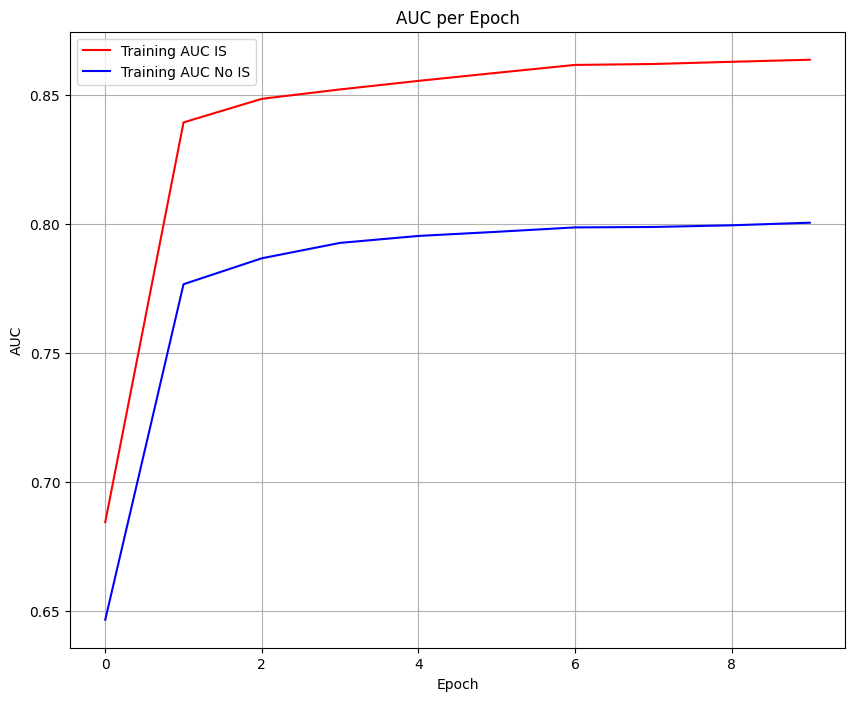

In [ ]:
# Plot MSE Loss
plt.figure(figsize=(10,8))
plt.plot(historyTrain['auc'], label='Training AUC IS', color='red')
plt.plot(historyTrainNoIS['auc'], label='Training AUC No IS', color='blue')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.title('AUC per Epoch')
plt.show()

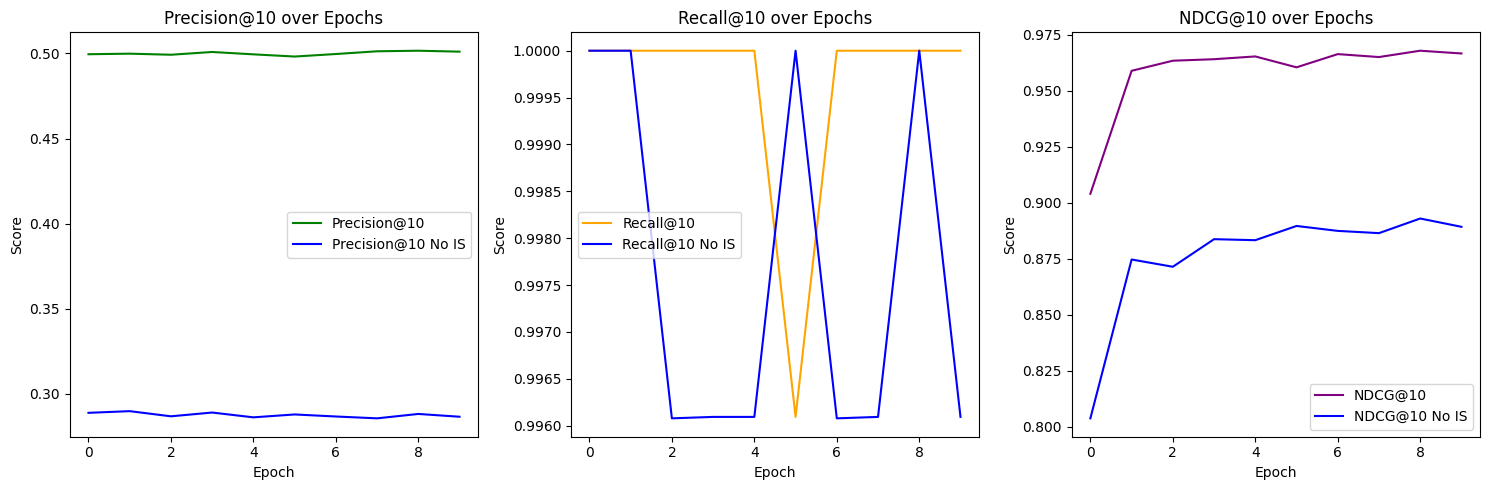

In [ ]:
k = 10
plt.figure(figsize=(15, 5))

# Precision@k
plt.subplot(1, 3, 1)
plt.plot(historyTrain[f'precision@{k}'], label=f'Precision@{k}', color='green')
plt.plot(historyTrainNoIS[f'precision@{k}'], label=f'Precision@{k} No IS', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title(f'Precision@{k} over Epochs')
plt.legend()

# Recall@k
plt.subplot(1, 3, 2)
plt.plot(historyTrain[f'recall@{k}'], label=f'Recall@{k}', color='orange')
plt.plot(historyTrainNoIS[f'recall@{k}'], label=f'Recall@{k} No IS', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title(f'Recall@{k} over Epochs')
plt.legend()

# NDCG@k
plt.subplot(1, 3, 3)
plt.plot(historyTrain[f'ndcg@{k}'], label=f'NDCG@{k}', color='purple')
plt.plot(historyTrainNoIS[f'ndcg@{k}'], label=f'NDCG@{k} No IS', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title(f'NDCG@{k} over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## **Hyperparameters**

### **Importance Sampling**

In [ ]:
# Konfigurasi hyperparameter
optimizers = ['adam']
learning_rates = [0.01, 0.001, 0.05]
max_epoch = 20
k = 10

best_ndcg = -1.0
best_config = None
all_results = []

# Loop hyperparameter
for opt_name in optimizers:
    for lr in learning_rates:
        print(f"\nTraining with {opt_name.upper()} | lr={lr}")

        # Inisialisasi model baru
        model = Model(
            hidden_channels=32,
            metadata=train_data.metadata(),
            num_nodes_dict=train_data.num_nodes_dict
        ).to(device)

        # Optimizer
        if opt_name == 'adam':
            optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)

        # Fungsi loss
        loss_fn = MSELoss()

        # Train model
        historyVal = train_with_hyperparams(
            model=model,
            train_loader=loader_is,
            val_loader=val_loader,
            loss_fn=loss_fn,
            device=device,
            optimizer=optimizer,
            sampled_edge_weight=sampled_edge_weight_is,
            max_epoch=max_epoch,
            k=k,
            epoch_desc=f"GridSearch-{opt_name.upper()}",
            patience=5
        )

        # Evaluasi hasil NDCG terbaik dari history
        if historyVal[f'ndcg@{k}']:
            ndcg_final = max(historyVal[f'ndcg@{k}'])
            best_ndcg_epoch = historyVal[f'ndcg@{k}'].index(ndcg_final)

            result = {
                "optimizer": opt_name,
                "lr": lr,
                "val_precision": historyVal[f'precision@{k}'][best_ndcg_epoch],
                "val_recall": historyVal[f'recall@{k}'][best_ndcg_epoch],
                "val_ndcg": ndcg_final,
                "val_auc": historyVal['auc'][best_ndcg_epoch],
            }

            all_results.append(result)

            if ndcg_final > best_ndcg:
                best_ndcg = ndcg_final
                best_config = result.copy()
        else:
            print("Warning: Empty validation result, skipping...")

# Tampilkan konfigurasi terbaik
if best_config:
    print("Best Configuration Based on Validation NDCG:")
    for key, value in best_config.items():
        print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

    # Simpan ke file JSON
    with open("best_config.json", "w") as f:
        json.dump(best_config, f, indent=4)
    print("Best config saved to 'best_config.json'")
else:
    print("No valid configuration found.")


Training with ADAM | lr=0.01


Precision@10: 0.2859 | Recall@10: 0.9922 | NDCG@10: 0.8294 | AUC: 0.7069
Epoch 0 | Val Precision@10: 0.2859, Recall@10: 0.9922, NDCG@10: 0.8294, AUC: 0.7069


Precision@10: 0.2878 | Recall@10: 0.9961 | NDCG@10: 0.8329 | AUC: 0.7144
Epoch 1 | Val Precision@10: 0.2878, Recall@10: 0.9961, NDCG@10: 0.8329, AUC: 0.7144


Precision@10: 0.2869 | Recall@10: 0.9961 | NDCG@10: 0.8355 | AUC: 0.7155
Epoch 2 | Val Precision@10: 0.2869, Recall@10: 0.9961, NDCG@10: 0.8355, AUC: 0.7155


Precision@10: 0.2869 | Recall@10: 0.9961 | NDCG@10: 0.8382 | AUC: 0.7185
Epoch 3 | Val Precision@10: 0.2869, Recall@10: 0.9961, NDCG@10: 0.8382, AUC: 0.7185


Precision@10: 0.2869 | Recall@10: 0.9961 | NDCG@10: 0.8355 | AUC: 0.7160
EarlyStopping counter: 1 out of 5
Epoch 4 | Val Precision@10: 0.2869, Recall@10: 0.9961, NDCG@10: 0.8355, AUC: 0.7160


Precision@10: 0.2882 | Recall@10: 1.0000 | NDCG@10: 0.8393 | AUC: 0.7186
Epoch 5 | Val Precision@10: 0.2882, Recall@10: 1.0000, NDCG@10: 0.8393, AUC: 0.7186


Precision@10: 0.2867 | Recall@10: 0.9961 | NDCG@10: 0.8361 | AUC: 0.7204
Epoch 6 | Val Precision@10: 0.2867, Recall@10: 0.9961, NDCG@10: 0.8361, AUC: 0.7204


Precision@10: 0.2889 | Recall@10: 1.0000 | NDCG@10: 0.8407 | AUC: 0.7197
EarlyStopping counter: 1 out of 5
Epoch 7 | Val Precision@10: 0.2889, Recall@10: 1.0000, NDCG@10: 0.8407, AUC: 0.7197


Precision@10: 0.2885 | Recall@10: 1.0000 | NDCG@10: 0.8413 | AUC: 0.7203
EarlyStopping counter: 2 out of 5
Epoch 8 | Val Precision@10: 0.2885, Recall@10: 1.0000, NDCG@10: 0.8413, AUC: 0.7203


Precision@10: 0.2891 | Recall@10: 1.0000 | NDCG@10: 0.8385 | AUC: 0.7167
EarlyStopping counter: 3 out of 5
Epoch 9 | Val Precision@10: 0.2891, Recall@10: 1.0000, NDCG@10: 0.8385, AUC: 0.7167


Precision@10: 0.2883 | Recall@10: 1.0000 | NDCG@10: 0.8419 | AUC: 0.7213
Epoch 10 | Val Precision@10: 0.2883, Recall@10: 1.0000, NDCG@10: 0.8419, AUC: 0.7213


Precision@10: 0.2887 | Recall@10: 1.0000 | NDCG@10: 0.8412 | AUC: 0.7197
EarlyStopping counter: 1 out of 5
Epoch 11 | Val Precision@10: 0.2887, Recall@10: 1.0000, NDCG@10: 0.8412, AUC: 0.7197


Precision@10: 0.2868 | Recall@10: 0.9961 | NDCG@10: 0.8379 | AUC: 0.7190
EarlyStopping counter: 2 out of 5
Epoch 12 | Val Precision@10: 0.2868, Recall@10: 0.9961, NDCG@10: 0.8379, AUC: 0.7190


Precision@10: 0.2861 | Recall@10: 0.9922 | NDCG@10: 0.8348 | AUC: 0.7197
EarlyStopping counter: 3 out of 5
Epoch 13 | Val Precision@10: 0.2861, Recall@10: 0.9922, NDCG@10: 0.8348, AUC: 0.7197


Precision@10: 0.2901 | Recall@10: 1.0000 | NDCG@10: 0.8436 | AUC: 0.7214
Epoch 14 | Val Precision@10: 0.2901, Recall@10: 1.0000, NDCG@10: 0.8436, AUC: 0.7214


Precision@10: 0.2876 | Recall@10: 0.9961 | NDCG@10: 0.8365 | AUC: 0.7190
EarlyStopping counter: 1 out of 5
Epoch 15 | Val Precision@10: 0.2876, Recall@10: 0.9961, NDCG@10: 0.8365, AUC: 0.7190


Precision@10: 0.2873 | Recall@10: 0.9961 | NDCG@10: 0.8366 | AUC: 0.7180
EarlyStopping counter: 2 out of 5
Epoch 16 | Val Precision@10: 0.2873, Recall@10: 0.9961, NDCG@10: 0.8366, AUC: 0.7180


Precision@10: 0.2891 | Recall@10: 1.0000 | NDCG@10: 0.8359 | AUC: 0.7166
EarlyStopping counter: 3 out of 5
Epoch 17 | Val Precision@10: 0.2891, Recall@10: 1.0000, NDCG@10: 0.8359, AUC: 0.7166


Precision@10: 0.2867 | Recall@10: 0.9961 | NDCG@10: 0.8358 | AUC: 0.7158
EarlyStopping counter: 4 out of 5
Epoch 18 | Val Precision@10: 0.2867, Recall@10: 0.9961, NDCG@10: 0.8358, AUC: 0.7158


Precision@10: 0.2904 | Recall@10: 1.0000 | NDCG@10: 0.8403 | AUC: 0.7167
EarlyStopping counter: 5 out of 5
Epoch 19 | Val Precision@10: 0.2904, Recall@10: 1.0000, NDCG@10: 0.8403, AUC: 0.7167
>> Early Stopping triggered!

Training with ADAM | lr=0.001


Precision@10: 0.2882 | Recall@10: 1.0000 | NDCG@10: 0.8051 | AUC: 0.6129
Epoch 0 | Val Precision@10: 0.2882, Recall@10: 1.0000, NDCG@10: 0.8051, AUC: 0.6129


Precision@10: 0.2880 | Recall@10: 0.9961 | NDCG@10: 0.8327 | AUC: 0.6975
Epoch 1 | Val Precision@10: 0.2880, Recall@10: 0.9961, NDCG@10: 0.8327, AUC: 0.6975


Precision@10: 0.2880 | Recall@10: 1.0000 | NDCG@10: 0.8408 | AUC: 0.7181
Epoch 2 | Val Precision@10: 0.2880, Recall@10: 1.0000, NDCG@10: 0.8408, AUC: 0.7181


Precision@10: 0.2876 | Recall@10: 0.9961 | NDCG@10: 0.8418 | AUC: 0.7268
Epoch 3 | Val Precision@10: 0.2876, Recall@10: 0.9961, NDCG@10: 0.8418, AUC: 0.7268


Precision@10: 0.2872 | Recall@10: 0.9961 | NDCG@10: 0.8425 | AUC: 0.7272
Epoch 4 | Val Precision@10: 0.2872, Recall@10: 0.9961, NDCG@10: 0.8425, AUC: 0.7272


Precision@10: 0.2893 | Recall@10: 0.9961 | NDCG@10: 0.8451 | AUC: 0.7292
Epoch 5 | Val Precision@10: 0.2893, Recall@10: 0.9961, NDCG@10: 0.8451, AUC: 0.7292


Precision@10: 0.2887 | Recall@10: 1.0000 | NDCG@10: 0.8431 | AUC: 0.7288
EarlyStopping counter: 1 out of 5
Epoch 6 | Val Precision@10: 0.2887, Recall@10: 1.0000, NDCG@10: 0.8431, AUC: 0.7288


Precision@10: 0.2872 | Recall@10: 0.9961 | NDCG@10: 0.8425 | AUC: 0.7321
Epoch 7 | Val Precision@10: 0.2872, Recall@10: 0.9961, NDCG@10: 0.8425, AUC: 0.7321


Precision@10: 0.2897 | Recall@10: 1.0000 | NDCG@10: 0.8481 | AUC: 0.7321
Epoch 8 | Val Precision@10: 0.2897, Recall@10: 1.0000, NDCG@10: 0.8481, AUC: 0.7321


Precision@10: 0.2863 | Recall@10: 0.9922 | NDCG@10: 0.8416 | AUC: 0.7350
Epoch 9 | Val Precision@10: 0.2863, Recall@10: 0.9922, NDCG@10: 0.8416, AUC: 0.7350


Precision@10: 0.2881 | Recall@10: 1.0000 | NDCG@10: 0.8475 | AUC: 0.7370
Epoch 10 | Val Precision@10: 0.2881, Recall@10: 1.0000, NDCG@10: 0.8475, AUC: 0.7370


Precision@10: 0.2856 | Recall@10: 0.9922 | NDCG@10: 0.8380 | AUC: 0.7368
EarlyStopping counter: 1 out of 5
Epoch 11 | Val Precision@10: 0.2856, Recall@10: 0.9922, NDCG@10: 0.8380, AUC: 0.7368


Precision@10: 0.2884 | Recall@10: 1.0000 | NDCG@10: 0.8476 | AUC: 0.7376
Epoch 12 | Val Precision@10: 0.2884, Recall@10: 1.0000, NDCG@10: 0.8476, AUC: 0.7376


Precision@10: 0.2869 | Recall@10: 0.9961 | NDCG@10: 0.8455 | AUC: 0.7385
Epoch 13 | Val Precision@10: 0.2869, Recall@10: 0.9961, NDCG@10: 0.8455, AUC: 0.7385


Precision@10: 0.2879 | Recall@10: 1.0000 | NDCG@10: 0.8485 | AUC: 0.7412
Epoch 14 | Val Precision@10: 0.2879, Recall@10: 1.0000, NDCG@10: 0.8485, AUC: 0.7412


Precision@10: 0.2883 | Recall@10: 1.0000 | NDCG@10: 0.8469 | AUC: 0.7458
Epoch 15 | Val Precision@10: 0.2883, Recall@10: 1.0000, NDCG@10: 0.8469, AUC: 0.7458


Precision@10: 0.2904 | Recall@10: 1.0000 | NDCG@10: 0.8513 | AUC: 0.7459
Epoch 16 | Val Precision@10: 0.2904, Recall@10: 1.0000, NDCG@10: 0.8513, AUC: 0.7459


Precision@10: 0.2868 | Recall@10: 0.9961 | NDCG@10: 0.8491 | AUC: 0.7573
Epoch 17 | Val Precision@10: 0.2868, Recall@10: 0.9961, NDCG@10: 0.8491, AUC: 0.7573


Precision@10: 0.2871 | Recall@10: 0.9961 | NDCG@10: 0.8502 | AUC: 0.7626
Epoch 18 | Val Precision@10: 0.2871, Recall@10: 0.9961, NDCG@10: 0.8502, AUC: 0.7626


Precision@10: 0.2883 | Recall@10: 0.9961 | NDCG@10: 0.8480 | AUC: 0.7593
EarlyStopping counter: 1 out of 5
Epoch 19 | Val Precision@10: 0.2883, Recall@10: 0.9961, NDCG@10: 0.8480, AUC: 0.7593

Training with ADAM | lr=0.05


Precision@10: 0.2877 | Recall@10: 1.0000 | NDCG@10: 0.7606 | AUC: 0.5001
Epoch 0 | Val Precision@10: 0.2877, Recall@10: 1.0000, NDCG@10: 0.7606, AUC: 0.5001


Precision@10: 0.2870 | Recall@10: 0.9961 | NDCG@10: 0.7592 | AUC: 0.4999
EarlyStopping counter: 1 out of 5
Epoch 1 | Val Precision@10: 0.2870, Recall@10: 0.9961, NDCG@10: 0.7592, AUC: 0.4999


Precision@10: 0.2891 | Recall@10: 1.0000 | NDCG@10: 0.7613 | AUC: 0.4997
EarlyStopping counter: 2 out of 5
Epoch 2 | Val Precision@10: 0.2891, Recall@10: 1.0000, NDCG@10: 0.7613, AUC: 0.4997


Precision@10: 0.2874 | Recall@10: 1.0000 | NDCG@10: 0.7611 | AUC: 0.5002
Epoch 3 | Val Precision@10: 0.2874, Recall@10: 1.0000, NDCG@10: 0.7611, AUC: 0.5002


Precision@10: 0.2870 | Recall@10: 0.9961 | NDCG@10: 0.7596 | AUC: 0.5003
Epoch 4 | Val Precision@10: 0.2870, Recall@10: 0.9961, NDCG@10: 0.7596, AUC: 0.5003


Precision@10: 0.2905 | Recall@10: 1.0000 | NDCG@10: 0.7616 | AUC: 0.5000
EarlyStopping counter: 1 out of 5
Epoch 5 | Val Precision@10: 0.2905, Recall@10: 1.0000, NDCG@10: 0.7616, AUC: 0.5000


Precision@10: 0.2877 | Recall@10: 1.0000 | NDCG@10: 0.7609 | AUC: 0.5000
EarlyStopping counter: 2 out of 5
Epoch 6 | Val Precision@10: 0.2877, Recall@10: 1.0000, NDCG@10: 0.7609, AUC: 0.5000


Precision@10: 0.2864 | Recall@10: 0.9961 | NDCG@10: 0.7583 | AUC: 0.5001
EarlyStopping counter: 3 out of 5
Epoch 7 | Val Precision@10: 0.2864, Recall@10: 0.9961, NDCG@10: 0.7583, AUC: 0.5001


Precision@10: 0.2894 | Recall@10: 1.0000 | NDCG@10: 0.7616 | AUC: 0.4986
EarlyStopping counter: 4 out of 5
Epoch 8 | Val Precision@10: 0.2894, Recall@10: 1.0000, NDCG@10: 0.7616, AUC: 0.4986


Precision@10: 0.2889 | Recall@10: 1.0000 | NDCG@10: 0.7612 | AUC: 0.5002
EarlyStopping counter: 5 out of 5
Epoch 9 | Val Precision@10: 0.2889, Recall@10: 1.0000, NDCG@10: 0.7612, AUC: 0.5002
>> Early Stopping triggered!
Best Configuration Based on Validation NDCG:
optimizer: adam
lr: 0.0010
val_precision: 0.2904
val_recall: 1.0000
val_ndcg: 0.8513
val_auc: 0.7459
Best config saved to 'best_config.json'


### **Training Ulang Importance Sampling**

In [ ]:
with open('best_config.json', 'r') as f:
     best_config = json.load(f)
best_opt=best_config['optimizer']
best_lr=best_config['lr']

print(best_config['optimizer'])
print(best_config['lr'])

best_model = Model(
    hidden_channels=32,
    metadata=train_data.metadata(),
    num_nodes_dict=train_data.num_nodes_dict
).to(device)

# Recreate the best optimizer based on best_config
best_optimizer = Adam(best_model.parameters(), lr=best_config['lr'], weight_decay=1e-4)

adam
0.001


In [ ]:
# Latih ulang model dengan hyperparameter terbaik pada data latih
historyTrainIS = train(
    model=best_model,
    loader=loader_is,
    loss_fn=loss_fn,
    device=device,
    sampled_edge_weight=sampled_edge_weight_is,
    optimizer=best_optimizer,
    epoch_desc="Final-Training-Best",
    max_epoch=10,
    k=10
)

======Training Session======


P@10: 0.5005 | R@10: 1.0000 | NDCG@10: 0.8745 | AUC: 0.5479 | Time: 100.07s | Total time: 100.07s


P@10: 0.4994 | R@10: 1.0000 | NDCG@10: 0.9495 | AUC: 0.7712 | Time: 105.07s | Total time: 205.14s


P@10: 0.4994 | R@10: 1.0000 | NDCG@10: 0.9660 | AUC: 0.8451 | Time: 102.64s | Total time: 307.78s


P@10: 0.4977 | R@10: 0.9961 | NDCG@10: 0.9641 | AUC: 0.8591 | Time: 100.77s | Total time: 408.54s


P@10: 0.5001 | R@10: 1.0000 | NDCG@10: 0.9687 | AUC: 0.8642 | Time: 107.37s | Total time: 515.91s


P@10: 0.4992 | R@10: 1.0000 | NDCG@10: 0.9684 | AUC: 0.8669 | Time: 109.17s | Total time: 625.08s


P@10: 0.4987 | R@10: 1.0000 | NDCG@10: 0.9696 | AUC: 0.8696 | Time: 114.39s | Total time: 739.47s


P@10: 0.5037 | R@10: 1.0000 | NDCG@10: 0.9712 | AUC: 0.8711 | Time: 107.05s | Total time: 846.52s


P@10: 0.5003 | R@10: 0.9961 | NDCG@10: 0.9676 | AUC: 0.8730 | Time: 107.38s | Total time: 953.89s


P@10: 0.4990 | R@10: 1.0000 | NDCG@10: 0.9715 | AUC: 0.8758 | Time: 103.90s | Total time: 1057.79s


### **Tes Importance Sampling**

In [ ]:
resultsTest_IS = evaluate(test_loader, best_model, device, k=10)

Precision@10: 0.4988 | Recall@10: 1.0000 | NDCG@10: 0.9719 | AUC: 0.8798


### **Uniform Sampling**

In [ ]:
# Konfigurasi hyperparameter
optimizers = ['adam']
learning_rates = [0.01, 0.001, 0.05]
max_epoch = 20
k = 10

best_ndcg = -1.0
best_config = None
all_results = []

# Loop hyperparameter
for opt_name in optimizers:
    for lr in learning_rates:
        print(f"\nTraining with {opt_name.upper()} | lr={lr}")

        # Inisialisasi model baru
        model = Model(
            hidden_channels=32,
            metadata=train_data.metadata(),
            num_nodes_dict=train_data.num_nodes_dict
        ).to(device)

        # Optimizer
        if opt_name == 'adam':
            optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)

        # Fungsi loss
        loss_fn = MSELoss()

        # Train model
        historyVal_Uniform = train_with_hyperparams(
            model=model,
            train_loader=loader_uniform,
            val_loader=val_loader,
            loss_fn=loss_fn,
            device=device,
            optimizer=optimizer,
            sampled_edge_weight=sampled_edge_weight_uniform,
            max_epoch=max_epoch,
            k=k,
            epoch_desc="Train-Val-Uniform",
            patience=5
        )

        # Evaluasi hasil NDCG terbaik dari history
        if historyVal_Uniform[f'ndcg@{k}']:
            ndcg_final = max(historyVal_Uniform[f'ndcg@{k}'])
            best_ndcg_epoch = historyVal_Uniform[f'ndcg@{k}'].index(ndcg_final)

            result = {
                "optimizer": opt_name,
                "lr": lr,
                "val_precision": historyVal_Uniform[f'precision@{k}'][best_ndcg_epoch],
                "val_recall": historyVal_Uniform[f'recall@{k}'][best_ndcg_epoch],
                "val_ndcg": ndcg_final,
                "val_auc": historyVal_Uniform['auc'][best_ndcg_epoch],
            }

            all_results.append(result)

            if ndcg_final > best_ndcg:
                best_ndcg = ndcg_final
                best_config_uniform = result.copy()
        else:
            print("Warning: Empty validation result, skipping...")

# Tampilkan konfigurasi terbaik
if best_config_uniform:
    print("Best Configuration Based on Validation NDCG:")
    for key, value in best_config_uniform.items():
        print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")


Training with ADAM | lr=0.01


Precision@10: 0.2870 | Recall@10: 0.9961 | NDCG@10: 0.7585 | AUC: 0.5004
Epoch 0 | Val Precision@10: 0.2870, Recall@10: 0.9961, NDCG@10: 0.7585, AUC: 0.5004


Precision@10: 0.2871 | Recall@10: 0.9961 | NDCG@10: 0.8349 | AUC: 0.7143
Epoch 1 | Val Precision@10: 0.2871, Recall@10: 0.9961, NDCG@10: 0.8349, AUC: 0.7143


Precision@10: 0.2870 | Recall@10: 0.9961 | NDCG@10: 0.8355 | AUC: 0.7176
Epoch 2 | Val Precision@10: 0.2870, Recall@10: 0.9961, NDCG@10: 0.8355, AUC: 0.7176


Precision@10: 0.2863 | Recall@10: 0.9922 | NDCG@10: 0.8314 | AUC: 0.7195
Epoch 3 | Val Precision@10: 0.2863, Recall@10: 0.9922, NDCG@10: 0.8314, AUC: 0.7195


Precision@10: 0.2882 | Recall@10: 1.0000 | NDCG@10: 0.8401 | AUC: 0.7190
EarlyStopping counter: 1 out of 5
Epoch 4 | Val Precision@10: 0.2882, Recall@10: 1.0000, NDCG@10: 0.8401, AUC: 0.7190


Precision@10: 0.2857 | Recall@10: 0.9922 | NDCG@10: 0.8347 | AUC: 0.7223
Epoch 5 | Val Precision@10: 0.2857, Recall@10: 0.9922, NDCG@10: 0.8347, AUC: 0.7223


Precision@10: 0.2889 | Recall@10: 1.0000 | NDCG@10: 0.8416 | AUC: 0.7206
EarlyStopping counter: 1 out of 5
Epoch 6 | Val Precision@10: 0.2889, Recall@10: 1.0000, NDCG@10: 0.8416, AUC: 0.7206


Precision@10: 0.2864 | Recall@10: 0.9961 | NDCG@10: 0.8388 | AUC: 0.7223
Epoch 7 | Val Precision@10: 0.2864, Recall@10: 0.9961, NDCG@10: 0.8388, AUC: 0.7223


Precision@10: 0.2892 | Recall@10: 1.0000 | NDCG@10: 0.8397 | AUC: 0.7188
EarlyStopping counter: 1 out of 5
Epoch 8 | Val Precision@10: 0.2892, Recall@10: 1.0000, NDCG@10: 0.8397, AUC: 0.7188


Precision@10: 0.2911 | Recall@10: 1.0000 | NDCG@10: 0.8409 | AUC: 0.7218
EarlyStopping counter: 2 out of 5
Epoch 9 | Val Precision@10: 0.2911, Recall@10: 1.0000, NDCG@10: 0.8409, AUC: 0.7218


Precision@10: 0.2867 | Recall@10: 0.9961 | NDCG@10: 0.8393 | AUC: 0.7211
EarlyStopping counter: 3 out of 5
Epoch 10 | Val Precision@10: 0.2867, Recall@10: 0.9961, NDCG@10: 0.8393, AUC: 0.7211


Precision@10: 0.2890 | Recall@10: 0.9961 | NDCG@10: 0.8377 | AUC: 0.7204
EarlyStopping counter: 4 out of 5
Epoch 11 | Val Precision@10: 0.2890, Recall@10: 0.9961, NDCG@10: 0.8377, AUC: 0.7204


Precision@10: 0.2876 | Recall@10: 1.0000 | NDCG@10: 0.8404 | AUC: 0.7221
EarlyStopping counter: 5 out of 5
Epoch 12 | Val Precision@10: 0.2876, Recall@10: 1.0000, NDCG@10: 0.8404, AUC: 0.7221
>> Early Stopping triggered!

Training with ADAM | lr=0.001


Precision@10: 0.2871 | Recall@10: 0.9961 | NDCG@10: 0.7880 | AUC: 0.5684
Epoch 0 | Val Precision@10: 0.2871, Recall@10: 0.9961, NDCG@10: 0.7880, AUC: 0.5684


Precision@10: 0.2889 | Recall@10: 1.0000 | NDCG@10: 0.8263 | AUC: 0.6550
Epoch 1 | Val Precision@10: 0.2889, Recall@10: 1.0000, NDCG@10: 0.8263, AUC: 0.6550


Precision@10: 0.2872 | Recall@10: 0.9961 | NDCG@10: 0.8404 | AUC: 0.7159
Epoch 2 | Val Precision@10: 0.2872, Recall@10: 0.9961, NDCG@10: 0.8404, AUC: 0.7159


Precision@10: 0.2870 | Recall@10: 0.9961 | NDCG@10: 0.8406 | AUC: 0.7239
Epoch 3 | Val Precision@10: 0.2870, Recall@10: 0.9961, NDCG@10: 0.8406, AUC: 0.7239


Precision@10: 0.2885 | Recall@10: 0.9961 | NDCG@10: 0.8410 | AUC: 0.7292
Epoch 4 | Val Precision@10: 0.2885, Recall@10: 0.9961, NDCG@10: 0.8410, AUC: 0.7292


Precision@10: 0.2879 | Recall@10: 0.9961 | NDCG@10: 0.8436 | AUC: 0.7321
Epoch 5 | Val Precision@10: 0.2879, Recall@10: 0.9961, NDCG@10: 0.8436, AUC: 0.7321


Precision@10: 0.2880 | Recall@10: 1.0000 | NDCG@10: 0.8450 | AUC: 0.7317
EarlyStopping counter: 1 out of 5
Epoch 6 | Val Precision@10: 0.2880, Recall@10: 1.0000, NDCG@10: 0.8450, AUC: 0.7317


Precision@10: 0.2917 | Recall@10: 1.0000 | NDCG@10: 0.8462 | AUC: 0.7319
EarlyStopping counter: 2 out of 5
Epoch 7 | Val Precision@10: 0.2917, Recall@10: 1.0000, NDCG@10: 0.8462, AUC: 0.7319


Precision@10: 0.2909 | Recall@10: 1.0000 | NDCG@10: 0.8487 | AUC: 0.7375
Epoch 8 | Val Precision@10: 0.2909, Recall@10: 1.0000, NDCG@10: 0.8487, AUC: 0.7375


Precision@10: 0.2890 | Recall@10: 1.0000 | NDCG@10: 0.8480 | AUC: 0.7346
EarlyStopping counter: 1 out of 5
Epoch 9 | Val Precision@10: 0.2890, Recall@10: 1.0000, NDCG@10: 0.8480, AUC: 0.7346


Precision@10: 0.2888 | Recall@10: 1.0000 | NDCG@10: 0.8479 | AUC: 0.7374
EarlyStopping counter: 2 out of 5
Epoch 10 | Val Precision@10: 0.2888, Recall@10: 1.0000, NDCG@10: 0.8479, AUC: 0.7374


Precision@10: 0.2898 | Recall@10: 1.0000 | NDCG@10: 0.8470 | AUC: 0.7374
EarlyStopping counter: 3 out of 5
Epoch 11 | Val Precision@10: 0.2898, Recall@10: 1.0000, NDCG@10: 0.8470, AUC: 0.7374


Precision@10: 0.2864 | Recall@10: 0.9922 | NDCG@10: 0.8381 | AUC: 0.7368
EarlyStopping counter: 4 out of 5
Epoch 12 | Val Precision@10: 0.2864, Recall@10: 0.9922, NDCG@10: 0.8381, AUC: 0.7368


Precision@10: 0.2883 | Recall@10: 0.9961 | NDCG@10: 0.8463 | AUC: 0.7402
Epoch 13 | Val Precision@10: 0.2883, Recall@10: 0.9961, NDCG@10: 0.8463, AUC: 0.7402


Precision@10: 0.2876 | Recall@10: 0.9961 | NDCG@10: 0.8447 | AUC: 0.7384
EarlyStopping counter: 1 out of 5
Epoch 14 | Val Precision@10: 0.2876, Recall@10: 0.9961, NDCG@10: 0.8447, AUC: 0.7384


Precision@10: 0.2909 | Recall@10: 1.0000 | NDCG@10: 0.8483 | AUC: 0.7397
EarlyStopping counter: 2 out of 5
Epoch 15 | Val Precision@10: 0.2909, Recall@10: 1.0000, NDCG@10: 0.8483, AUC: 0.7397


Precision@10: 0.2868 | Recall@10: 0.9961 | NDCG@10: 0.8447 | AUC: 0.7411
Epoch 16 | Val Precision@10: 0.2868, Recall@10: 0.9961, NDCG@10: 0.8447, AUC: 0.7411


Precision@10: 0.2887 | Recall@10: 1.0000 | NDCG@10: 0.8486 | AUC: 0.7445
Epoch 17 | Val Precision@10: 0.2887, Recall@10: 1.0000, NDCG@10: 0.8486, AUC: 0.7445


Precision@10: 0.2883 | Recall@10: 0.9961 | NDCG@10: 0.8481 | AUC: 0.7543
Epoch 18 | Val Precision@10: 0.2883, Recall@10: 0.9961, NDCG@10: 0.8481, AUC: 0.7543


Precision@10: 0.2871 | Recall@10: 0.9961 | NDCG@10: 0.8519 | AUC: 0.7624
Epoch 19 | Val Precision@10: 0.2871, Recall@10: 0.9961, NDCG@10: 0.8519, AUC: 0.7624

Training with ADAM | lr=0.05


Precision@10: 0.2870 | Recall@10: 0.9961 | NDCG@10: 0.7588 | AUC: 0.4995
Epoch 0 | Val Precision@10: 0.2870, Recall@10: 0.9961, NDCG@10: 0.7588, AUC: 0.4995


Precision@10: 0.2908 | Recall@10: 1.0000 | NDCG@10: 0.7596 | AUC: 0.4972
EarlyStopping counter: 1 out of 5
Epoch 1 | Val Precision@10: 0.2908, Recall@10: 1.0000, NDCG@10: 0.7596, AUC: 0.4972


Precision@10: 0.2882 | Recall@10: 0.9961 | NDCG@10: 0.7593 | AUC: 0.4999
Epoch 2 | Val Precision@10: 0.2882, Recall@10: 0.9961, NDCG@10: 0.7593, AUC: 0.4999


Precision@10: 0.2886 | Recall@10: 1.0000 | NDCG@10: 0.7613 | AUC: 0.5000
Epoch 3 | Val Precision@10: 0.2886, Recall@10: 1.0000, NDCG@10: 0.7613, AUC: 0.5000


Precision@10: 0.2874 | Recall@10: 0.9961 | NDCG@10: 0.7584 | AUC: 0.5000
Epoch 4 | Val Precision@10: 0.2874, Recall@10: 0.9961, NDCG@10: 0.7584, AUC: 0.5000


Precision@10: 0.2898 | Recall@10: 1.0000 | NDCG@10: 0.7606 | AUC: 0.4998
EarlyStopping counter: 1 out of 5
Epoch 5 | Val Precision@10: 0.2898, Recall@10: 1.0000, NDCG@10: 0.7606, AUC: 0.4998


Precision@10: 0.2928 | Recall@10: 1.0000 | NDCG@10: 0.7632 | AUC: 0.4991
EarlyStopping counter: 2 out of 5
Epoch 6 | Val Precision@10: 0.2928, Recall@10: 1.0000, NDCG@10: 0.7632, AUC: 0.4991


Precision@10: 0.2882 | Recall@10: 0.9961 | NDCG@10: 0.7590 | AUC: 0.4999
EarlyStopping counter: 3 out of 5
Epoch 7 | Val Precision@10: 0.2882, Recall@10: 0.9961, NDCG@10: 0.7590, AUC: 0.4999


Precision@10: 0.2867 | Recall@10: 0.9961 | NDCG@10: 0.7586 | AUC: 0.4998
EarlyStopping counter: 4 out of 5
Epoch 8 | Val Precision@10: 0.2867, Recall@10: 0.9961, NDCG@10: 0.7586, AUC: 0.4998


Precision@10: 0.2880 | Recall@10: 0.9961 | NDCG@10: 0.7579 | AUC: 0.4997
EarlyStopping counter: 5 out of 5
Epoch 9 | Val Precision@10: 0.2880, Recall@10: 0.9961, NDCG@10: 0.7579, AUC: 0.4997
>> Early Stopping triggered!
Best Configuration Based on Validation NDCG:
optimizer: adam
lr: 0.0010
val_precision: 0.2871
val_recall: 0.9961
val_ndcg: 0.8519
val_auc: 0.7624
Best config saved to 'best_config_uniform.json'


### **Training ulang uniform sampling**

In [ ]:
best_model_uniform = Model(
    hidden_channels=32,
    metadata=train_data.metadata(),
    num_nodes_dict=train_data.num_nodes_dict
).to(device)

# Recreate the best optimizer based on best_config
best_optimizer = Adam(best_model_uniform.parameters(), lr=0.001, weight_decay=1e-4)

adam
0.001


In [ ]:
# Latih ulang model dengan hyperparameter terbaik pada data latih
historyTrainUniform = train(
    model=best_model_uniform,
    loader=loader_uniform,
    loss_fn=loss_fn,
    device=device,
    sampled_edge_weight=sampled_edge_weight_uniform,
    optimizer=best_optimizer,
    epoch_desc="Final-Training-Best",
    max_epoch=10,
    k=10
)

======Training Session======


P@10: 0.2863 | R@10: 1.0000 | NDCG@10: 0.7662 | AUC: 0.5228 | Time: 91.94s | Total time: 91.94s


P@10: 0.2860 | R@10: 1.0000 | NDCG@10: 0.8346 | AUC: 0.6588 | Time: 91.42s | Total time: 183.36s


P@10: 0.2835 | R@10: 0.9922 | NDCG@10: 0.8748 | AUC: 0.7633 | Time: 91.34s | Total time: 274.70s


P@10: 0.2867 | R@10: 1.0000 | NDCG@10: 0.8914 | AUC: 0.7946 | Time: 90.97s | Total time: 365.67s


P@10: 0.2880 | R@10: 1.0000 | NDCG@10: 0.8939 | AUC: 0.7995 | Time: 90.02s | Total time: 455.70s


P@10: 0.2848 | R@10: 0.9961 | NDCG@10: 0.8907 | AUC: 0.8021 | Time: 89.94s | Total time: 545.63s


P@10: 0.2897 | R@10: 1.0000 | NDCG@10: 0.8974 | AUC: 0.8042 | Time: 89.68s | Total time: 635.32s


P@10: 0.2855 | R@10: 1.0000 | NDCG@10: 0.8973 | AUC: 0.8043 | Time: 90.73s | Total time: 726.05s


P@10: 0.2848 | R@10: 0.9961 | NDCG@10: 0.8939 | AUC: 0.8054 | Time: 94.60s | Total time: 820.65s


P@10: 0.2884 | R@10: 1.0000 | NDCG@10: 0.8969 | AUC: 0.8070 | Time: 106.78s | Total time: 927.43s


### **Testing uniform sampling**

In [ ]:
resultsTest_uniform = evaluate(loader_uniform, best_model_uniform, device, k=10)

Precision@10: 0.2845 | Recall@10: 0.9961 | NDCG@10: 0.8983 | AUC: 0.8147
